# Classification and Model Evaluation
## Module 6-7, Lab 4: Building and Evaluating Classification Models

Classification is one of the most common machine learning tasks. In this lab, you'll learn how to build classification models and evaluate their performance using various metrics and techniques.

### Learning Objectives
By the end of this lab, you will be able to:
- Build logistic regression and decision tree classifiers
- Understand the difference between regression and classification
- Evaluate classification models using multiple metrics
- Interpret confusion matrices and ROC curves
- Use cross-validation for robust model assessment
- Handle class imbalance in datasets

### Business Problem
We'll predict employee attrition (whether an employee will leave the company) based on various factors. This is crucial for HR departments to identify at-risk employees and take preventive measures.

## Setup and Data Loading

In [1]:
# Install required packages
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


### Creating an Employee Attrition Dataset
We'll create a realistic dataset for predicting employee attrition.

In [3]:
# Create a realistic employee attrition dataset
np.random.seed(42)
n_employees = 1500

# Generate employee features
employee_data = {
    'age': np.random.normal(35, 10, n_employees),
    'years_at_company': np.random.exponential(4, n_employees),
    'salary': np.random.normal(75000, 20000, n_employees),
    'satisfaction_score': np.random.normal(7, 2, n_employees),
    'performance_rating': np.random.normal(3.5, 0.8, n_employees),
    'work_life_balance': np.random.normal(3, 1, n_employees),
    'commute_distance': np.random.exponential(15, n_employees),
    'overtime_hours': np.random.exponential(5, n_employees),
    'department': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance'],
                                  n_employees, p=[0.35, 0.25, 0.15, 0.15, 0.1]),
    'job_level': np.random.choice(['Junior', 'Mid', 'Senior', 'Manager'],
                                 n_employees, p=[0.3, 0.4, 0.25, 0.05]),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'],
                                 n_employees, p=[0.15, 0.5, 0.3, 0.05]),
    'remote_work': np.random.choice([0, 1], n_employees, p=[0.7, 0.3]),
    'has_promotion_last_year': np.random.choice([0, 1], n_employees, p=[0.85, 0.15])
}

# Create DataFrame
df = pd.DataFrame(employee_data)

# Apply realistic constraints
df['age'] = np.clip(df['age'], 22, 65)
df['years_at_company'] = np.clip(df['years_at_company'], 0, df['age'] - 22)
df['salary'] = np.clip(df['salary'], 35000, 150000)
df['satisfaction_score'] = np.clip(df['satisfaction_score'], 1, 10)
df['performance_rating'] = np.clip(df['performance_rating'], 1, 5)
df['work_life_balance'] = np.clip(df['work_life_balance'], 1, 5)
df['commute_distance'] = np.clip(df['commute_distance'], 1, 50)
df['overtime_hours'] = np.clip(df['overtime_hours'], 0, 20)

print(f"Dataset created with {len(df)} employees")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset created with 1500 employees
Dataset shape: (1500, 13)


,age,years_at_company,salary,satisfaction_score,performance_rating,work_life_balance,commute_distance,overtime_hours,department,job_level,education,remote_work,has_promotion_last_year
0,39.967142,1.257861,84997.282475,8.595688,4.185390,1.709058,7.821299,5.149134,Finance,Junior,Bachelor,1,0
1,33.617357,6.973007,47013.876504,3.281326,3.818439,2.593026,2.737912,9.871094,Engineering,Senior,High School,0,1
2,41.476885,2.758658,82352.985860,7.090983,3.815664,3.014005,1.000000,3.331804,Marketing,Mid,Bachelor,1,0
3,50.230299,0.320757,35000.000000,8.116673,3.159396,3.563788,2.147342,0.721991,Sales,Mid,High School,1,0
4,32.658466,0.241340,87510.160337,10.000000,3.860397,2.408605,15.946715,1.708264,Marketing,Junior,Bachelor,0,0


### Creating the Target Variable (Attrition)
We'll create a realistic attrition target based on the features.

In [4]:
# Create attrition probability based on realistic factors
# Lower satisfaction, poor work-life balance, long commute, excessive overtime increase attrition
attrition_probability = (
    0.1 +  # Base probability
    (10 - df['satisfaction_score']) * 0.05 +  # Lower satisfaction increases risk
    (5 - df['work_life_balance']) * 0.03 +    # Poor work-life balance increases risk
    (df['commute_distance'] / 50) * 0.15 +    # Longer commute increases risk
    (df['overtime_hours'] / 20) * 0.1 +       # More overtime increases risk
    (df['years_at_company'] < 1) * 0.2 +      # New employees more likely to leave
    (df['years_at_company'] > 10) * 0.05 +    # Very tenured employees slightly more likely to leave
    (df['performance_rating'] < 2.5) * 0.15 + # Poor performers more likely to leave
    (df['has_promotion_last_year'] == 0) * 0.05  # No recent promotion increases risk
)

# Ensure probabilities are between 0 and 1
attrition_probability = np.clip(attrition_probability, 0, 0.8)

# Generate binary attrition outcome
df['attrition'] = np.random.binomial(1, attrition_probability)

print(f"Attrition rate: {df['attrition'].mean():.2%}")
print(f"Employees who left: {df['attrition'].sum()}")
print(f"Employees who stayed: {len(df) - df['attrition'].sum()}")

Attrition rate: 49.27%
Employees who left: 739
Employees who stayed: 761


## Step 1: Exploratory Data Analysis for Classification
Let's understand the relationship between features and attrition.

In [5]:
# Basic statistics by attrition status
print("=== ATTRITION ANALYSIS ===")
print(f"\n📊 Overall Statistics:")
print(f"   • Total employees: {len(df):,}")
print(f"   • Attrition rate: {df['attrition'].mean():.1%}")
print(f"   • Employees who left: {df['attrition'].sum():,}")
print(f"   • Employees who stayed: {(df['attrition'] == 0).sum():,}")

# Compare numerical features by attrition status
numerical_cols = ['age', 'years_at_company', 'salary', 'satisfaction_score',
                 'performance_rating', 'work_life_balance', 'commute_distance', 'overtime_hours']

print(f"\n📈 Average Values by Attrition Status:")
comparison = df.groupby('attrition')[numerical_cols].mean()
print(comparison.round(2))

=== ATTRITION ANALYSIS ===

📊 Overall Statistics:
   • Total employees: 1,500
   • Attrition rate: 49.3%
   • Employees who left: 739
   • Employees who stayed: 761

📈 Average Values by Attrition Status:
             age  years_at_company    salary  satisfaction_score  \
attrition                                                          
0          36.39               3.6  74805.46                7.18   
1          35.28               2.8  74377.76                6.60   

           performance_rating  work_life_balance  commute_distance  \
attrition                                                            
0                        3.50               3.06             13.82   
1                        3.42               2.99             15.71   

           overtime_hours  
attrition                  
0                    4.76  
1                    4.96  


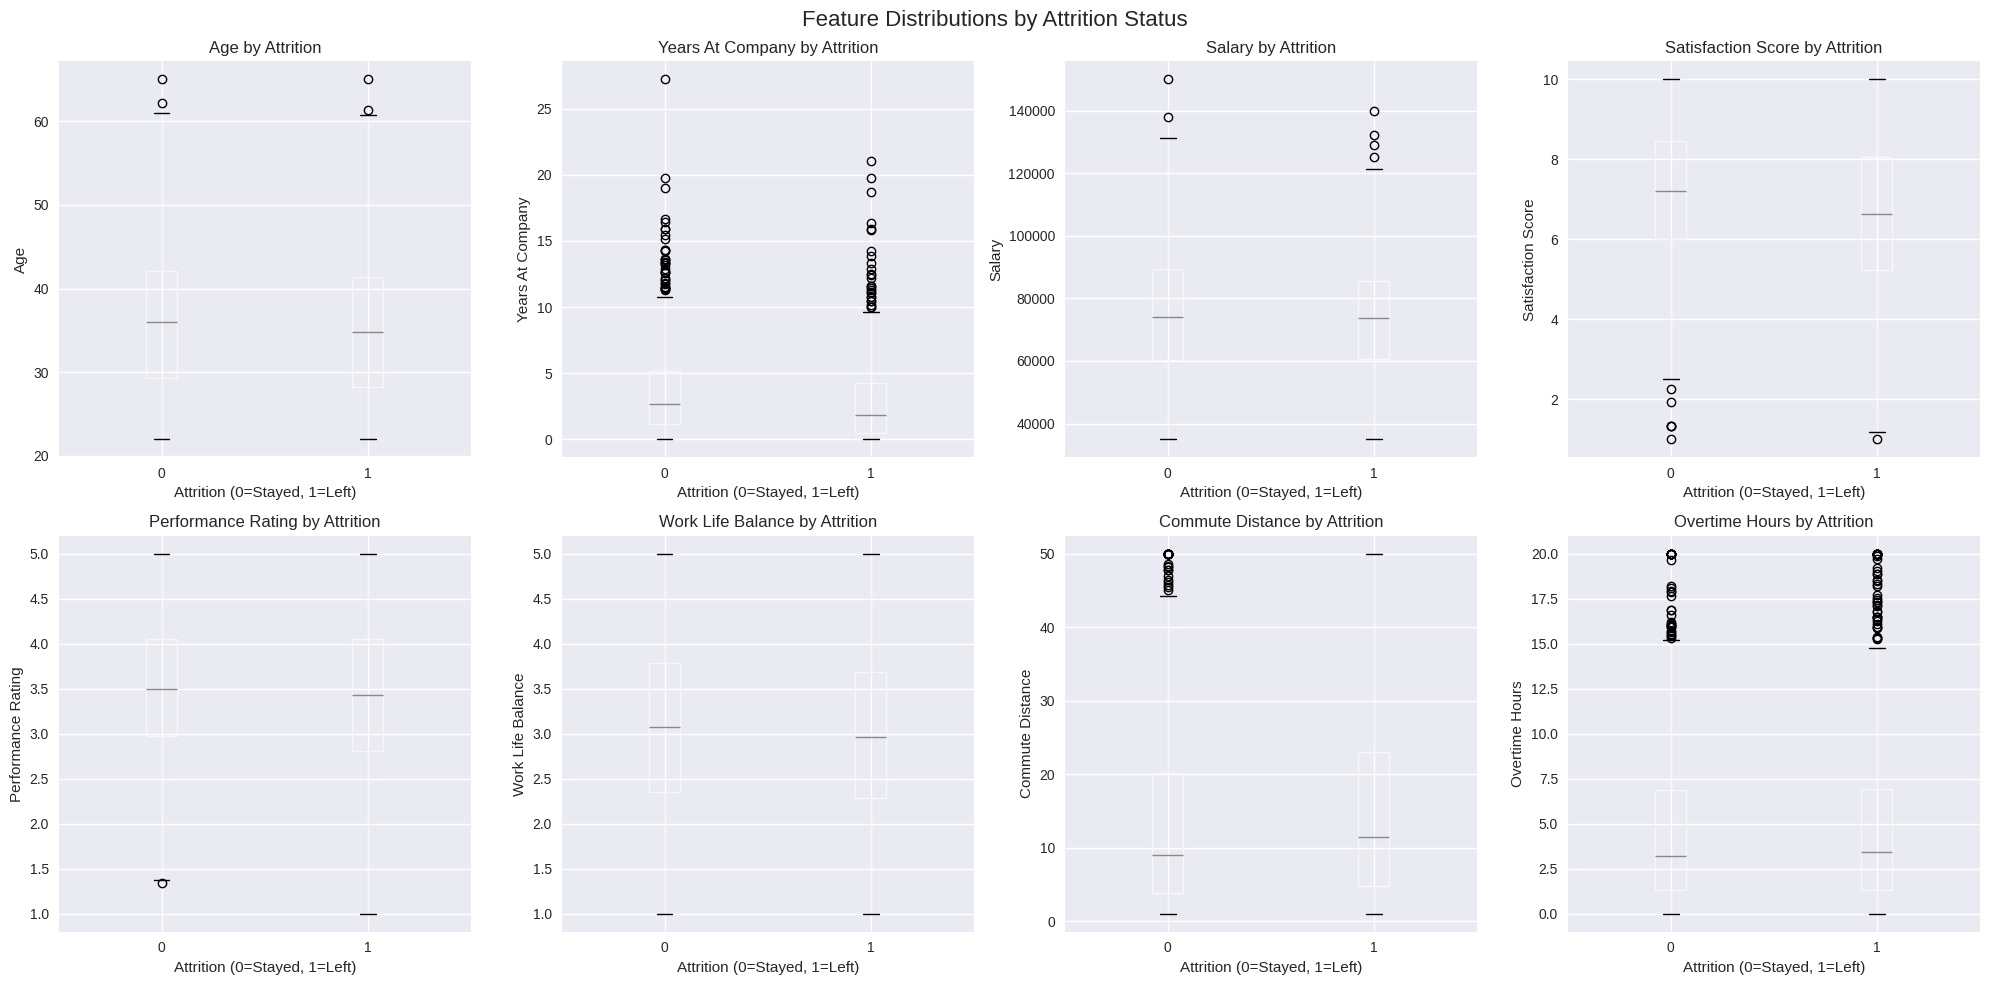

In [6]:
# Visualize the differences between groups
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Box plot comparing attrition groups
    df.boxplot(column=col, by='attrition', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} by Attrition')
    axes[i].set_xlabel('Attrition (0=Stayed, 1=Left)')
    axes[i].set_ylabel(col.replace("_", " ").title())

plt.suptitle('Feature Distributions by Attrition Status', fontsize=16)
plt.tight_layout()
plt.show()

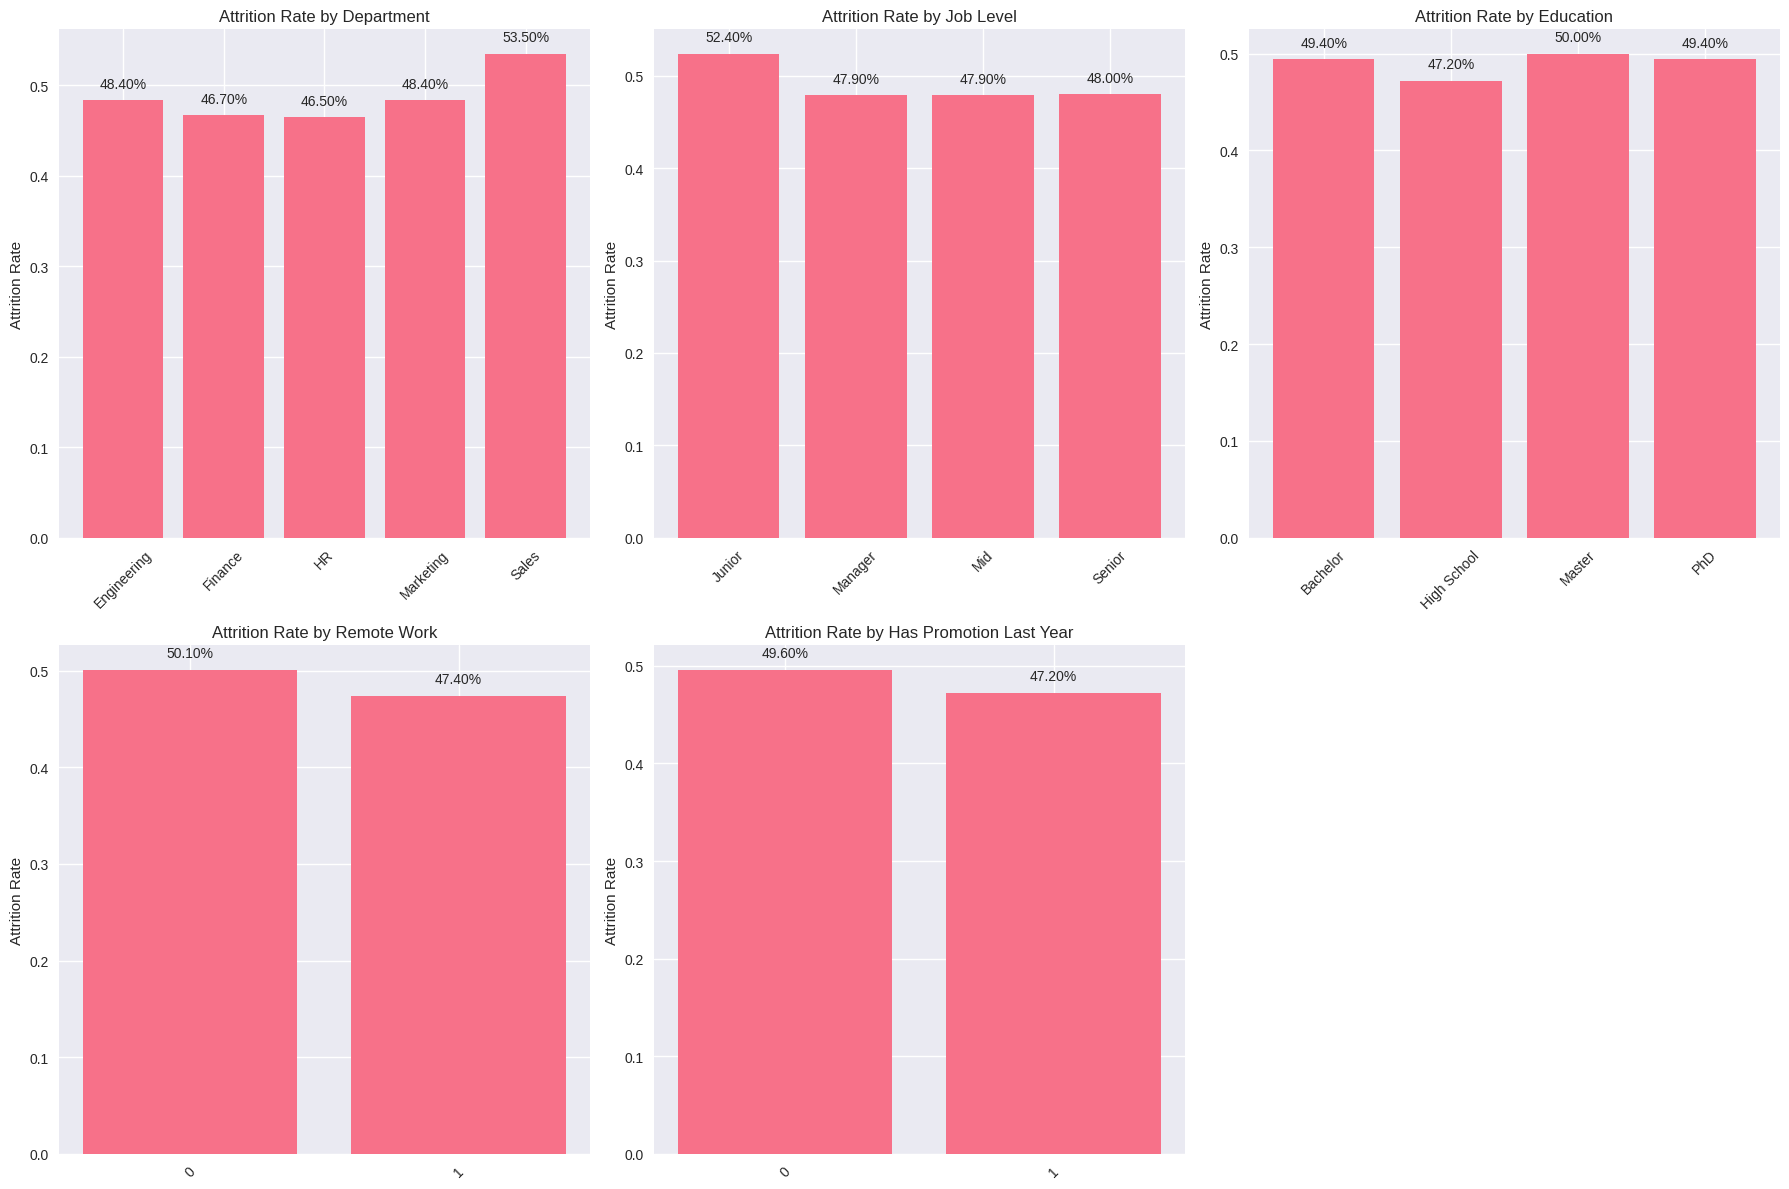


Detailed Attrition Analysis by Category:

Department:
             Total  Left Attrition_Rate
department                             
Engineering    498   241          48.4%
Finance        137    64          46.7%
HR             254   118          46.5%
Marketing      213   103          48.4%
Sales          398   213          53.5%

Job Level:
           Total  Left Attrition_Rate
job_level                            
Junior       437   229          52.4%
Manager       71    34          47.9%
Mid          609   292          47.9%
Senior       383   184          48.0%

Education:
             Total  Left Attrition_Rate
education                              
Bachelor       747   369          49.4%
High School    214   101          47.2%
Master         462   231          50.0%
PhD             77    38          49.4%

Remote Work:
             Total  Left Attrition_Rate
remote_work                            
0             1019   511          50.1%
1              481   228          47.4%

In [7]:
# Analyze categorical variables
categorical_cols = ['department', 'job_level', 'education', 'remote_work', 'has_promotion_last_year']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Calculate attrition rate by category
    attrition_by_cat = df.groupby(col)['attrition'].agg(['count', 'sum', 'mean']).round(3)
    attrition_by_cat.columns = ['Total', 'Left', 'Attrition_Rate']

    # Plot attrition rate
    axes[i].bar(attrition_by_cat.index.astype(str), attrition_by_cat['Attrition_Rate'])
    axes[i].set_title(f'Attrition Rate by {col.replace("_", " ").title()}')
    axes[i].set_ylabel('Attrition Rate')
    axes[i].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for j, v in enumerate(attrition_by_cat['Attrition_Rate']):
        axes[i].text(j, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\nDetailed Attrition Analysis by Category:")
for col in categorical_cols:
    print(f"\n{col.replace('_', ' ').title()}:")
    attrition_by_cat = df.groupby(col)['attrition'].agg(['count', 'sum', 'mean'])
    attrition_by_cat.columns = ['Total', 'Left', 'Attrition_Rate']
    attrition_by_cat['Attrition_Rate'] = attrition_by_cat['Attrition_Rate'].apply(lambda x: f"{x:.1%}")
    print(attrition_by_cat)

## Step 2: Data Preparation for Classification
Let's prepare our data for machine learning models.

In [8]:
# Prepare features and target
# Select features for modeling
feature_columns = numerical_cols + categorical_cols
X = df[feature_columns]
y = df['attrition']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True).round(3)}")

Features shape: (1500, 13)
Target shape: (1500,)

Features: ['age', 'years_at_company', 'salary', 'satisfaction_score', 'performance_rating', 'work_life_balance', 'commute_distance', 'overtime_hours', 'department', 'job_level', 'education', 'remote_work', 'has_promotion_last_year']

Target distribution:
attrition
0    761
1    739
Name: count, dtype: int64

Class balance: attrition
0    0.507
1    0.493
Name: proportion, dtype: float64


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True).round(3))
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True).round(3))

Training set: 1200 samples
Test set: 300 samples

Training set class distribution:
attrition
0    0.507
1    0.492
Name: proportion, dtype: float64

Test set class distribution:
attrition
0    0.507
1    0.493
Name: proportion, dtype: float64


In [10]:
# Create preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numerical and categorical columns
numerical_features = numerical_cols
categorical_features = categorical_cols

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# Get feature names after preprocessing
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = num_feature_names + list(cat_feature_names)
print(f"\nTotal features after preprocessing: {len(all_feature_names)}")

Processed training set shape: (1200, 20)
Processed test set shape: (300, 20)

Total features after preprocessing: 20


## Step 3: Building Classification Models
Let's build and compare different classification algorithms.

### 3.1 Logistic Regression

In [11]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_processed)
y_test_pred_lr = lr_model.predict(X_test_processed)
y_test_pred_proba_lr = lr_model.predict_proba(X_test_processed)[:, 1]

print("Logistic Regression Model Trained!")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred_lr):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_lr):.3f}")

Logistic Regression Model Trained!
Training accuracy: 0.589
Test accuracy: 0.597


Top 10 Most Important Features (Logistic Regression):
                      feature  coefficient  abs_coefficient
12          job_level_Manager      -0.3966           0.3966
14           job_level_Senior      -0.3483           0.3483
3          satisfaction_score      -0.2961           0.2961
1            years_at_company      -0.2330           0.2330
13              job_level_Mid      -0.2328           0.2328
11           department_Sales       0.2296           0.2296
8          department_Finance      -0.2067           0.2067
18              remote_work_1      -0.1967           0.1967
9               department_HR      -0.1813           0.1813
19  has_promotion_last_year_1      -0.1128           0.1128


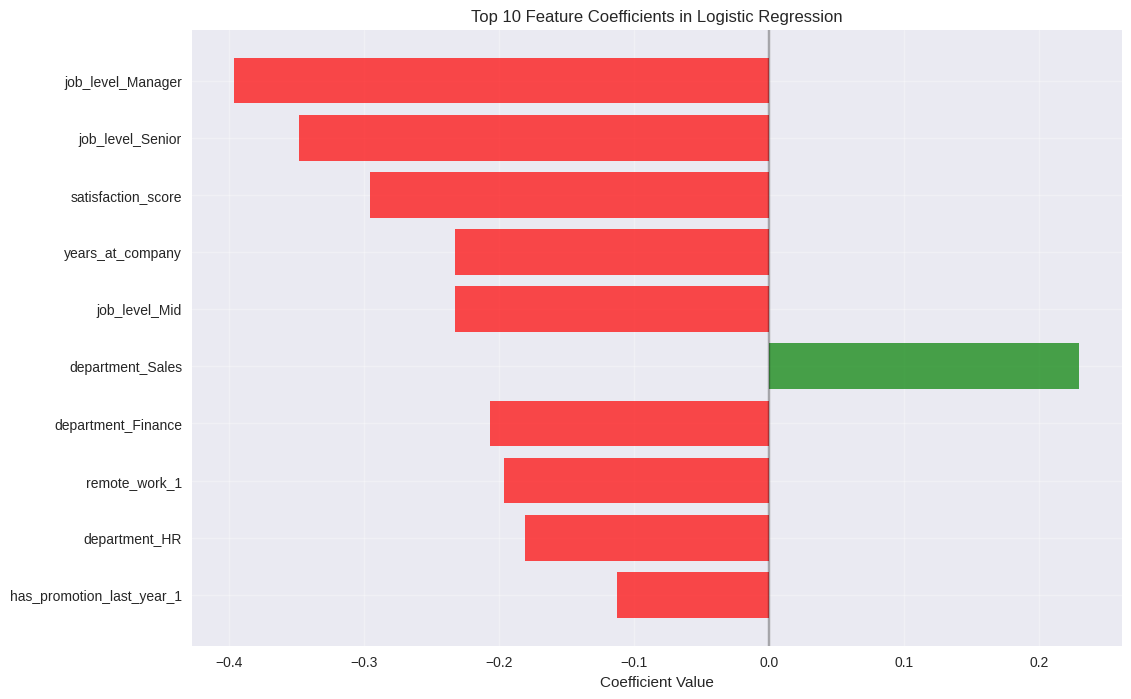

In [12]:
# Analyze feature importance in logistic regression
feature_importance_lr = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features (Logistic Regression):")
print(feature_importance_lr.head(10).round(4))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_lr.head(10)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients in Logistic Regression')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

### 3.2 Decision Tree

In [ ]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=50, min_samples_leaf=20)
dt_model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred_dt = dt_model.predict(X_train_processed)
y_test_pred_dt = dt_model.predict(X_test_processed)
y_test_pred_proba_dt = dt_model.predict_proba(X_test_processed)[:, 1]

print("Decision Tree Model Trained!")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred_dt):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_dt):.3f}")

In [ ]:
# Analyze feature importance in decision tree
feature_importance_dt = pd.DataFrame({
    'feature': all_feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Decision Tree):")
print(feature_importance_dt.head(10).round(4))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_dt = feature_importance_dt.head(10)
plt.barh(range(len(top_features_dt)), top_features_dt['importance'], alpha=0.7)
plt.yticks(range(len(top_features_dt)), top_features_dt['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Visualize a simplified decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model,
          feature_names=all_feature_names,
          class_names=['Stayed', 'Left'],
          filled=True,
          max_depth=3,  # Show only top 3 levels for readability
          fontsize=10)
plt.title('Decision Tree Visualization (Top 3 Levels)')
plt.show()

## Step 4: Model Evaluation
Let's comprehensively evaluate our models using various metrics.

### 4.1 Basic Metrics

In [ ]:
# Calculate evaluation metrics for both models
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

# Evaluate both models
lr_metrics = evaluate_model(y_test, y_test_pred_lr, y_test_pred_proba_lr, 'Logistic Regression')
dt_metrics = evaluate_model(y_test, y_test_pred_dt, y_test_pred_proba_dt, 'Decision Tree')

# Create comparison DataFrame
results_df = pd.DataFrame([lr_metrics, dt_metrics])
results_df = results_df.set_index('Model')

print("Model Comparison:")
print(results_df.round(4))

# Visualize the comparison
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, alpha=0.8)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Confusion Matrices

In [ ]:
# Create confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree Confusion Matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
axes[1].set_title('Decision Tree\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Interpret confusion matrices
print("Confusion Matrix Interpretation:")
print("\nLogistic Regression:")
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
print(f"  True Negatives (Correctly predicted stayed): {tn_lr}")
print(f"  False Positives (Incorrectly predicted left): {fp_lr}")
print(f"  False Negatives (Incorrectly predicted stayed): {fn_lr}")
print(f"  True Positives (Correctly predicted left): {tp_lr}")

print("\nDecision Tree:")
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()
print(f"  True Negatives (Correctly predicted stayed): {tn_dt}")
print(f"  False Positives (Incorrectly predicted left): {fp_dt}")
print(f"  False Negatives (Incorrectly predicted stayed): {fn_dt}")
print(f"  True Positives (Correctly predicted left): {tp_dt}")

### 4.3 ROC Curves

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_pred_proba_dt)
auc_dt = roc_auc_score(y_test, y_test_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', linewidth=2)

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("ROC Curve Interpretation:")
print("• AUC = 0.5: Random classifier (no predictive power)")
print("• AUC = 1.0: Perfect classifier")
print("• Higher AUC = Better model performance")
print("• The curve closer to the top-left corner is better")

### 4.4 Detailed Classification Reports

In [ ]:
# Print detailed classification reports
print("=== DETAILED CLASSIFICATION REPORTS ===")
print("\nLogistic Regression:")
print(classification_report(y_test, y_test_pred_lr, target_names=['Stayed', 'Left']))

print("\nDecision Tree:")
print(classification_report(y_test, y_test_pred_dt, target_names=['Stayed', 'Left']))

print("\n=== METRIC EXPLANATIONS ===")
print("• Precision: Of all predicted positives, how many were actually positive?")
print("• Recall: Of all actual positives, how many did we correctly identify?")
print("• F1-Score: Harmonic mean of precision and recall")
print("• Support: Number of actual occurrences of each class")

## Step 5: Cross-Validation
Let's use cross-validation for more robust model evaluation.

In [ ]:
# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Logistic Regression
cv_scores_lr = cross_val_score(lr_model, X_train_processed, y_train, cv=cv, scoring='roc_auc')

# Cross-validation for Decision Tree
cv_scores_dt = cross_val_score(dt_model, X_train_processed, y_train, cv=cv, scoring='roc_auc')

print("Cross-Validation Results (ROC-AUC):")
print(f"\nLogistic Regression:")
print(f"  Individual fold scores: {cv_scores_lr.round(4)}")
print(f"  Mean CV score: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

print(f"\nDecision Tree:")
print(f"  Individual fold scores: {cv_scores_dt.round(4)}")
print(f"  Mean CV score: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
plt.boxplot([cv_scores_lr, cv_scores_dt], labels=['Logistic Regression', 'Decision Tree'])
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation Performance Comparison')
plt.grid(True, alpha=0.3)
plt.show()

## Step 6: Model Interpretation and Business Insights
Let's extract actionable insights from our models.

In [ ]:
# Analyze prediction probabilities
# Create risk categories based on predicted probabilities
def categorize_risk(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.6:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Apply to logistic regression predictions (generally more calibrated)
risk_categories = [categorize_risk(p) for p in y_test_pred_proba_lr]
risk_df = pd.DataFrame({
    'actual_attrition': y_test,
    'predicted_probability': y_test_pred_proba_lr,
    'risk_category': risk_categories
})

# Analyze risk categories
risk_analysis = risk_df.groupby('risk_category').agg({
    'actual_attrition': ['count', 'sum', 'mean'],
    'predicted_probability': 'mean'
}).round(3)

risk_analysis.columns = ['Total_Employees', 'Actual_Attrition', 'Attrition_Rate', 'Avg_Predicted_Prob']

print("Risk Category Analysis:")
print(risk_analysis)

# Visualize risk categories
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Risk category distribution
risk_counts = risk_df['risk_category'].value_counts()
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Risk Categories')

# Attrition rate by risk category
axes[1].bar(risk_analysis.index, risk_analysis['Attrition_Rate'])
axes[1].set_title('Actual Attrition Rate by Risk Category')
axes[1].set_ylabel('Attrition Rate')
axes[1].set_xlabel('Risk Category')

# Add value labels on bars
for i, v in enumerate(risk_analysis['Attrition_Rate']):
    axes[1].text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Business insights and recommendations
print("=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===")

# Top risk factors from logistic regression
top_risk_factors = feature_importance_lr.head(5)
print("\n🎯 Top 5 Attrition Risk Factors:")
for idx, row in top_risk_factors.iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"   • {row['feature']}: {direction} attrition risk (coef: {row['coefficient']:.3f})")

# Model performance summary
print(f"\n📊 Model Performance Summary:")
best_model = "Logistic Regression" if auc_lr > auc_dt else "Decision Tree"
best_auc = max(auc_lr, auc_dt)
print(f"   • Best performing model: {best_model} (AUC: {best_auc:.3f})")
print(f"   • Model can identify {risk_analysis.loc['High Risk', 'Attrition_Rate']:.1%} of high-risk employees")
print(f"   • {risk_analysis.loc['High Risk', 'Total_Employees']} employees classified as high-risk")

# Actionable recommendations
print(f"\n💡 Actionable Recommendations:")
print(f"   1. Focus retention efforts on {risk_analysis.loc['High Risk', 'Total_Employees']} high-risk employees")
print(f"   2. Address low satisfaction scores - strongest predictor of attrition")
print(f"   3. Improve work-life balance programs")
print(f"   4. Consider remote work options to reduce commute impact")
print(f"   5. Monitor new employees closely (< 1 year tenure)")
print(f"   6. Implement regular performance feedback and development programs")

# Cost-benefit analysis
avg_replacement_cost = 50000  # Typical cost to replace an employee
high_risk_employees = risk_analysis.loc['High Risk', 'Total_Employees']
expected_attrition = high_risk_employees * risk_analysis.loc['High Risk', 'Attrition_Rate']
potential_savings = expected_attrition * avg_replacement_cost

print(f"\n💰 Potential Cost Savings:")
print(f"   • Expected attrition from high-risk group: {expected_attrition:.0f} employees")
print(f"   • Potential cost savings if 50% retention improvement: ${potential_savings * 0.5:,.0f}")
print(f"   • ROI of targeted retention programs could be substantial")

## Challenge: Your Turn to Practice!
Now it's your turn to apply classification techniques.

### Challenge 1: Feature Engineering
Create a new feature called 'tenure_satisfaction_ratio' (years_at_company / satisfaction_score) and retrain the logistic regression model. Does this improve performance?

In [18]:
# Your code here for Challenge 1
# Hint: Create the new feature, add it to your feature set, and retrain the model

# Create the new feature 'tenure_satisfaction_ratio'
df['tenure_satisfaction_ratio'] = df['years_at_company'] / df['satisfaction_score']

# Select features for modeling, including the new feature
feature_columns_challenge1 = numerical_cols + categorical_cols + ['tenure_satisfaction_ratio']
X_challenge1 = df[feature_columns_challenge1]
y_challenge1 = df['attrition']

# Split the data
X_train_challenge1, X_test_challenge1, y_train_challenge1, y_test_challenge1 = train_test_split(
    X_challenge1, y_challenge1, test_size=0.2, random_state=42, stratify=y_challenge1
)

# Define numerical and categorical columns for preprocessing
numerical_features_challenge1 = numerical_cols + ['tenure_satisfaction_ratio']
categorical_features_challenge1 = categorical_cols

# Create preprocessing steps
preprocessor_challenge1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_challenge1),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_challenge1)
    ]
)

# Fit and transform the data
X_train_processed_challenge1 = preprocessor_challenge1.fit_transform(X_train_challenge1)
X_test_processed_challenge1 = preprocessor_challenge1.transform(X_test_challenge1)

# Train Logistic Regression with the new feature
lr_model_challenge1 = LogisticRegression(random_state=42, max_iter=1000)
lr_model_challenge1.fit(X_train_processed_challenge1, y_train_challenge1)

# Make predictions
y_test_pred_lr_challenge1 = lr_model_challenge1.predict(X_test_processed_challenge1)
y_test_pred_proba_lr_challenge1 = lr_model_challenge1.predict_proba(X_test_processed_challenge1)[:, 1]

# Evaluate the model
auc_challenge1 = roc_auc_score(y_test_challenge1, y_test_pred_proba_lr_challenge1)
auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr) # Calculate auc_lr here
print("Challenge 1: Logistic Regression with 'tenure_satisfaction_ratio'")
print(f"Test ROC-AUC with new feature: {auc_challenge1:.4f}")
print(f"Original Test ROC-AUC: {auc_lr:.4f}")

# Compare performance
if auc_challenge1 > auc_lr:
    print("Adding 'tenure_satisfaction_ratio' improved ROC-AUC.")
else:
    print("Adding 'tenure_satisfaction_ratio' did not improve ROC-AUC.")

Challenge 1: Logistic Regression with 'tenure_satisfaction_ratio'
Test ROC-AUC with new feature: 0.6335
Original Test ROC-AUC: 0.6326
Adding 'tenure_satisfaction_ratio' improved ROC-AUC.


### Challenge 2: Threshold Optimization
The default classification threshold is 0.5. Find the optimal threshold that maximizes the F1-score for the logistic regression model.

Challenge 2: Optimal Threshold for Logistic Regression (Maximizing F1-Score)
Optimal Threshold: 0.25
Maximum F1-Score at optimal threshold: 0.6622


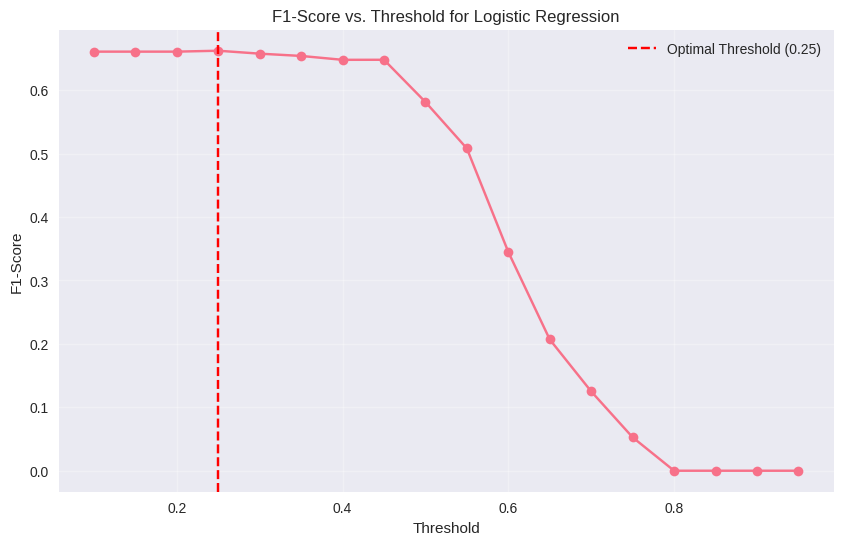

In [19]:
# Your code here for Challenge 2
# Hint: Try different thresholds from 0.1 to 0.9 and calculate F1-score for each

# Find the optimal threshold that maximizes the F1-score for the logistic regression model.

best_f1 = 0
optimal_threshold = 0.5

# Evaluate F1-score for a range of thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_test_pred_proba_lr > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print("Challenge 2: Optimal Threshold for Logistic Regression (Maximizing F1-Score)")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Maximum F1-Score at optimal threshold: {best_f1:.4f}")

# Visualize F1-score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Threshold for Logistic Regression')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Challenge 3: Class Imbalance
Our dataset has class imbalance. Try using class weights in logistic regression to handle this. Compare the results with the original model.

Challenge 3: Logistic Regression with Class Weights

Model Performance Comparison (Original vs. Balanced):
                                Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                                         
Logistic Regression (Original)    0.5967     0.5957  0.5676    0.5813   0.6326
Logistic Regression (Balanced)    0.5967     0.5882  0.6081    0.5980   0.6325


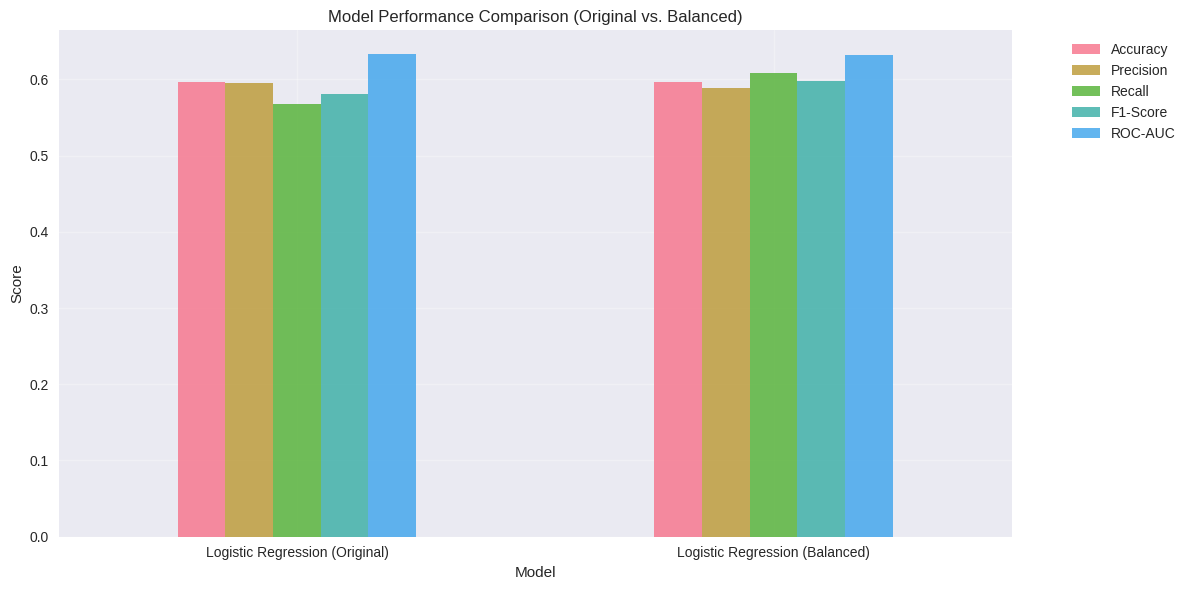


Interpretation:
Compare Precision, Recall, and F1-Score for 'Left' class (attrition=1).
Using 'balanced' class weight typically improves Recall for the minority class
(attrition=1), potentially at the cost of Precision.


In [20]:
# Your code here for Challenge 3
# Hint: Use class_weight='balanced' parameter in LogisticRegression

# Calculate evaluation metrics for both models
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

# Train Logistic Regression with class_weight='balanced'
lr_model_balanced = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Use the original processed training data from Step 2
lr_model_balanced.fit(X_train_processed, y_train)

# Make predictions
y_test_pred_lr_balanced = lr_model_balanced.predict(X_test_processed)
y_test_pred_proba_lr_balanced = lr_model_balanced.predict_proba(X_test_processed)[:, 1]

# Evaluate the model
lr_balanced_metrics = evaluate_model(y_test, y_test_pred_lr_balanced, y_test_pred_proba_lr_balanced, 'Logistic Regression (Balanced)')

print("Challenge 3: Logistic Regression with Class Weights")
print("\nModel Performance Comparison (Original vs. Balanced):")

# Create comparison DataFrame including original LR metrics
original_lr_metrics = evaluate_model(y_test, y_test_pred_lr, y_test_pred_proba_lr, 'Logistic Regression (Original)')
results_balanced_df = pd.DataFrame([original_lr_metrics, lr_balanced_metrics]).set_index('Model')

print(results_balanced_df.round(4))

# Optional: Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
results_balanced_df.plot(kind='bar', ax=ax, alpha=0.8)
plt.title('Model Performance Comparison (Original vs. Balanced)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret changes, especially in Precision and Recall
print("\nInterpretation:")
print("Compare Precision, Recall, and F1-Score for 'Left' class (attrition=1).")
print("Using 'balanced' class weight typically improves Recall for the minority class")
print("(attrition=1), potentially at the cost of Precision.")

## Summary

Congratulations! You've mastered the fundamentals of classification and model evaluation. Here's what you've learned:

### ✅ Key Skills Mastered:
1. **Classification Algorithms**: Logistic regression and decision trees
2. **Model Evaluation**: Accuracy, precision, recall, F1-score, ROC-AUC
3. **Confusion Matrices**: Understanding true/false positives and negatives
4. **ROC Curves**: Visualizing model performance across thresholds
5. **Cross-Validation**: Robust model assessment using multiple folds
6. **Feature Importance**: Understanding which features drive predictions
7. **Business Application**: Translating model results into actionable insights

### 🔍 Key Concepts Learned:
- **Precision vs Recall Trade-off**: High precision = fewer false alarms, high recall = catch more positives
- **ROC-AUC**: Measures model's ability to distinguish between classes
- **Cross-Validation**: Provides more reliable performance estimates
- **Feature Interpretation**: Logistic regression coefficients show feature impact direction
- **Business Value**: Models must translate to actionable business decisions

### 🚀 Next Steps:
In the next lab, we'll explore ensemble methods that combine multiple models to achieve better performance:
- Random Forests (bagging)
- Gradient Boosting (boosting)
- Model stacking and voting
- Hyperparameter tuning

### 📚 Additional Resources:
- [Scikit-learn Classification Guide](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Understanding ROC Curves](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
- [Precision vs Recall](https://towardsdatascience.com/precision-vs-recall-386cf9f89488)
- [Cross-Validation Explained](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85)